# Алгоритм автоматической застройки участка

## Вводные

### Описание задания

Необходимо разработать алгоритм автоматического распределения территорий на участке с учётом заданных параметров. 

На **вход** подаются координаты участка в формате GeoJSON и ключевые градостроительные ограничения. 

На **выходе** – GeoJSON-файл с информацией о расположении объектов и изображение плана застройки.

### Входные данные
Программа должна принимать следующие параметры:
1. Границы участка – передаются в формате GeoJSON (FeatureCollection с Polygon).

2. Ограничения по плотности застройки – процент площади участка, допустимый для застройки.

3. Минимальное расстояние между объектами – например, 10 метров между зданиями.

4. Дополнительные ограничения – наличие дорог, лесов, водоемов, на которых нельзя строить (также передаются в GeoJSON).

### Задачи
1. Разделить участок на логические зоны (например, жилая застройка, парки, дороги).

2. Разместить объекты (здания, дороги, зеленые зоны) с учётом заданных ограничений, исключая застройку в запрещенных зонах (дороги, леса, водоемы).

3. Сформировать GeoJSON-файл с координатами размещённых объектов.

4. Сгенерировать изображение плана участка.

5. Различные варианты.

6. Задача формы.

### Выходные данные
1. Файл GeoJSON с информацией об объектах на участке в формате:
```json
{
"type": "FeatureCollection",
"features": [
	{"type": "Feature", "properties": {"type": "residential"}, "geometry": {"type": "Polygon", "coordinates": [[...]]}},
	{"type": "Feature", "properties": {"type": "commercial"}, "geometry": {"type": "Polygon", "coordinates": [[...]]}},
	{"type": "Feature", "properties": {"type": "road"}, "geometry": {"type": "LineString", "coordinates": [[...]]}},
	{"type": "Feature", "properties": {"type": "park"}, "geometry": {"type": "Polygon", "coordinates": [[...]]}}
]
}
```
2. Изображение (.png или .jpg) с графическим представлением застройки участка.


# Предварительные размышления
4 зоны - резиденция, коммерция, дрога, парк

Задаются какие-то ограничения(дополнительные). 
+ пересечения
+ форма объектов 
+ количество
+ объекты наверное должны быть соеденены дорогами.
+ процент плотности
+ минимальное расстояние

### Общая структура
1. Сдклать сеть
2. Разместить опорные точки
3. Расширить объекты
4. Сделать дороги
5. Сохранить

# Реализация

,name,restriction,geometry,color
0,Зона застройки,None,"POLYGON ((37.6173 55.7558, 37.6179 55.7565, 37...",grey
1,Лесная зона,no_build,"POLYGON ((37.618 55.756, 37.6185 55.7565, 37.6...",red
2,Дорога,no_build,"LINESTRING (37.6175 55.7555, 37.6185 55.7555)",red


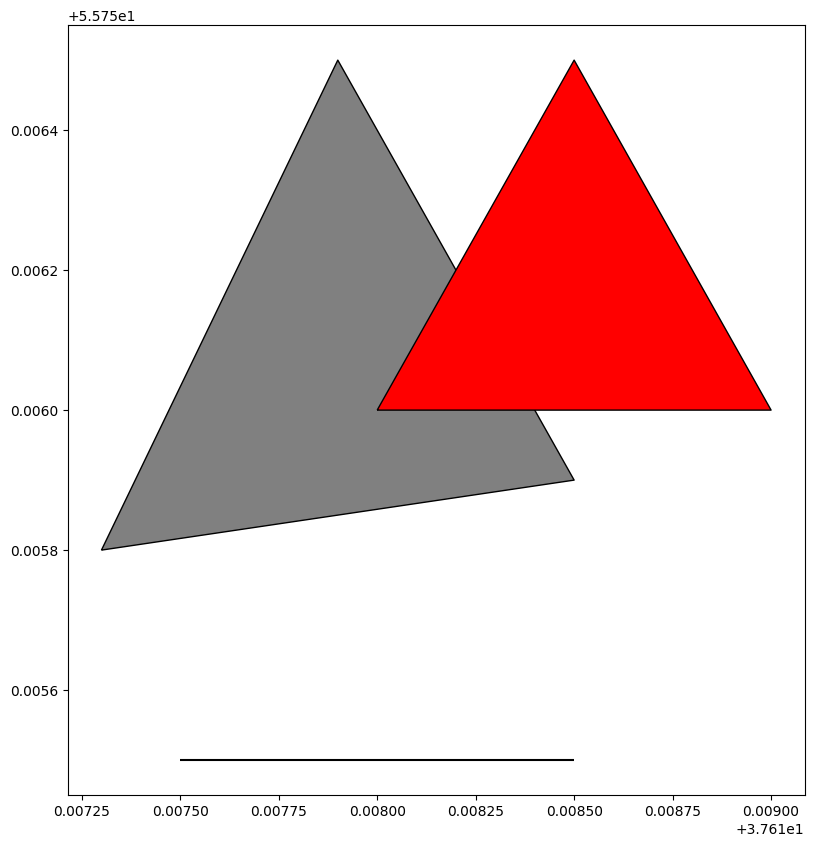

In [1]:
import geopandas as gpd
import pandas as pd
import shapely as sh
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

DF = gpd.read_file('data.geojson')
DF['restriction'] = DF['restriction'].astype(str)
DF.loc[DF['restriction'] == 'None', 'color'] = 'grey'
DF.loc[DF['restriction'] == 'no_build', 'color'] = 'red'
DF.plot(figsize=(10,10), edgecolor='black', facecolor=DF['color'])
DF

In [2]:
names = ['residential', 'commercial', 'park'] # Доступные типы зон
shapes = ['round', 'square', 'hexagon', 'rectangle', 'triangle'] # Доступные формы

OBJECTS_DF = pd.DataFrame(
    {
        'name': ['residential', 'residential', 'residential', 'commercial', 'park'],
        'shape': ['round', 'triangle', 'square', 'rectangle', 'hexagon'],
        'amount': [1, 1, 2, 1, 1]
    }
)

OBJECTS_DF

,name,shape,amount
0,residential,round,1
1,residential,triangle,1
2,residential,square,2
3,commercial,rectangle,1
4,park,hexagon,1


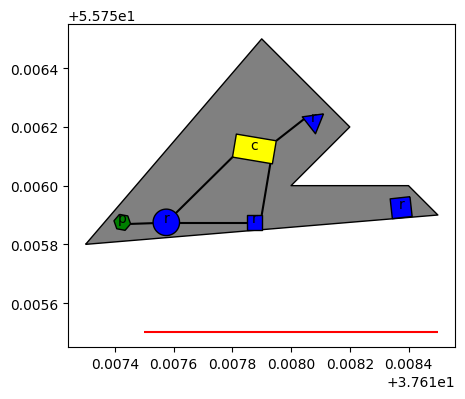

In [3]:
class Cell:
    def __init__(self, 
                 xmin: float, ymin: float, 
                 xmax: float, ymax: float, 
                 building_zone: sh.Polygon, 
                 roads: list[sh.LineString]) -> None:
        """
        Инициализирует класс ячейки сетки. В котором храниться полигон ячейки, 
        её статус(возможность использования в качестве опорной точки) и её центр.

        Args:
            xmin (float): min x координата
            ymin (float): min y координата
            xmax (float): max x координата
            ymax (float): max y координата
            building_zone (sh.Polygon): зона для постройки 
            roads (list[sh.LineString]): список дорог
        """
        self.polygon = sh.geometry.Polygon(
            [(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)]
        )
        self.status = None if self.polygon.equals(
            self.polygon.intersection(building_zone)) else False
        for road in roads:
            if road.intersects(self.polygon):
                self.status = False
                break
        self.center = self.polygon.centroid
        self.name = ''

    def __repr__(self):
        return f'Name: {self.name}\n{self.polygon}\nStatus inds: {self.status}\n'


class Plan:
    def __init__(
        self,
        zones: gpd.GeoDataFrame,
        objects: pd.DataFrame,
        aviable_area_rate: float,
        minimal_distance: float
    ) -> None:
        """
        Args:
            zones (gpd.GeoDataFrame): набор зон
            objects (pd.DataFrame): набор объектов для размещения
            aviable_area_rate (float): коэффициент плотность застройки (0..1]
            minimal_distance (float): минимальное расстояние между объектами
        """

        assert 0 < aviable_area_rate <= 1, "Значение коэффициента плотности вне пределов"

        self.cmap = {
            'residential': 'blue',
            'commercial': 'yellow',
            'park': 'green'
        }

        self.zones = zones
        self.objects = objects
        self.aviable_area_rate = aviable_area_rate
        self.minimal_distance = minimal_distance
        self.number_of_objects = objects['amount'].sum()

        full_building_zone = sh.unary_union(
            self.zones.loc[self.zones['restriction'] == 'None', 'geometry']
        )

        # Место доступное для застройки
        self.building_zone = (
            full_building_zone
            .difference(
                sh.unary_union(
                    self.zones.loc[self.zones['restriction']
                                   == 'no_build', 'geometry']
                )
            )
        )

        # Доступная площадь для застройки
        self.aviable_area = full_building_zone.area * self.aviable_area_rate
        if self.aviable_area > self.building_zone.area:
            self.remaining_area = self.building_zone.area
        else:
            self.remaining_area = self.aviable_area

        # Максимальная площадь объекта при равномерном заполнении
        self.average_max_area = self.remaining_area / self.number_of_objects

    def make_grid(self) -> None:
        """
        Создает сеть для планирования и распределяет опорные точки с учетом ограничений
        """
        # Задание границ сети
        self.xmin, self.ymin, self.xmax, self.ymax = self.building_zone.bounds
        total_width = self.xmax - self.xmin
        total_height = self.ymax - self.ymin

        # Задание размера ячейки и инициализация сети
        # Задание размера таким образом, с учетом последющей логике,
        # гарантирует не вырождаемость объектов
        cell_shape = self.minimal_distance
        grid_width = int(np.ceil(total_width / cell_shape))
        grid_height = int(np.ceil(total_height / cell_shape))
        grid = np.full((grid_width, grid_height), None)

        grid_df = {'name': [], 'geometry': [], 'color': []}

        # Заполняем сеть полигонами, и устанавливаем флаги непригодности
        for i in range(grid_width):
            for j in range(grid_height):
                grid[i][j] = Cell(
                    self.xmin + cell_shape * i,
                    self.ymin + cell_shape * j,
                    self.xmin + cell_shape * (i + 1),
                    self.ymin + cell_shape * (j + 1),
                    self.building_zone,
                    self.zones.loc[self.zones['name'] == 'Дорога', 'geometry']
                )
                grid_df['name'].append(f'{i}_{j}')
                grid_df['geometry'].append(grid[i][j].polygon)

        suggested_cells, validated_cells = [], []

        # Инициализация стартовой точки для распределения
        while True:
            base_point = grid[np.random.randint(
                0, grid_width)][np.random.randint(0, grid_height)]
            if base_point.status != False:
                base_point.status = True
                suggested_cells.append(base_point)
                validated_cells.append(base_point)
                break
        
        # Поиск подходящих мест для объектов
        while len(suggested_cells) > 0:
            suggested_idx = np.random.randint(len(suggested_cells))
            suggested_cell = suggested_cells[suggested_idx]
            found_flag = False
            for _ in range(1000):
                # прибавление ширины ячейки отсекает ложные точки
                r = np.random.uniform(2*self.minimal_distance, 10 * self.minimal_distance) + np.sqrt(self.average_max_area)
                phi = np.random.uniform(0, 2 * np.pi)

                # Координаты новой точки и ее ячейка
                x = suggested_cell.center.x + r * np.cos(phi)
                y = suggested_cell.center.y + r * np.sin(phi)
                grid_x = int((x - self.xmin) // cell_shape)
                grid_y = int((y - self.ymin) // cell_shape)

                # Этот ужас проверяет наличие ячейки, ее валидность и расстояние от уже подтвержденных
                # расстояние проверяется между ячейками, а не центроидами, что отсекает риск ложновалидных точек
                # при успехе запоминаем новую точку
                if (
                    grid_x in range(0, grid_width) and
                    grid_y in range(0, grid_height) and
                    grid[grid_x][grid_y].status == None and
                    all(grid[grid_x][grid_y].polygon.distance(p.polygon)
                        >= self.minimal_distance for p in validated_cells)
                ):

                    grid[grid_x][grid_y].status = True
                    suggested_cells.append(grid[grid_x][grid_y])
                    validated_cells.append(grid[grid_x][grid_y])
                    found_flag = True
                    break
            
            # Если точка не результативна или нашли достаточно
            if not found_flag:
                suggested_cells.pop(suggested_idx)
            if len(validated_cells) >= self.number_of_objects:
                break

        self.places_cells = validated_cells
        return validated_cells

    def balance_clusters(self):
        """
        Получаем группы точек и балансируем их для каждой категории
        """
        zones = self.objects.groupby('name')['amount'].sum()
        n_clusters, size_of_clusters, cluster_names = len(
            zones), zones.to_list(), zones.index.to_list()

        self.objects['temp'] = self.objects['amount'].apply(lambda x: [1] * x)
        self.objects = self.objects.explode('temp').drop(
            columns=['temp', 'amount']).reset_index(drop=True)
        
        # Начальная кластеризация
        coords = np.array([[polygon.center.x, polygon.center.y]
                          for polygon in self.places_cells])
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)
        labels = kmeans.labels_

        # Балансировка кластеров
        for _ in range(100):
            cluster_sizes = np.bincount(labels, minlength=n_clusters)
            overfilled = np.where(cluster_sizes > size_of_clusters)[0]
            underfilled = np.where(cluster_sizes < size_of_clusters)[0]

            # Находим ближайшую точку к центру группы
            if len(overfilled) == 0: break
            for of, uf in zip(overfilled, underfilled):
                target_point = kmeans.cluster_centers_[uf]
                distances = np.linalg.norm(
                    coords[labels == of] - target_point, axis=1)
                idx_in_ov = np.where(labels == of)[0][np.argmin(distances)]
                labels[idx_in_ov] = uf

        # Сопоставляем полученные кластеры и полученные ранее опорные точки
        self.objects.sort_values('name', inplace=True)
        pairs = np.array([[cluster_names[label], idx]
                         for label, idx in zip(labels, range(len(self.places_cells)))])
        pairs = pairs[pairs[:, 0].argsort()]
        self.objects['place_idx'] = pairs[:, 1]
        self.objects['place_idx'] = self.objects['place_idx'].apply(int)

    def generate_poygon(self, shape: str, centroid: sh.Point, r: float) -> sh.Polygon:
        """Создание полигона нужной формы в окружности с центром и радиусом

        Args:
            shape (str): тип фигуры
            centroid (sh.Point): центр фигуры
            r (float): радиус фигуры

        Returns:
            sh.Polygon: полигон фигуры
        """
        if shape == 'round':
            return centroid.buffer(r)
        
        if shape == 'square':
            return centroid.buffer(r, cap_style='square')
        
        if shape == 'rectangle':
            angles = np.deg2rad([30, 150, 210, 330])
            r = np.sqrt(r**2 + (r/2)**2)
            x = centroid.x + r * np.cos(angles)
            y = centroid.y + r * np.sin(angles)
            return sh.Polygon(np.column_stack((x, y)))
        
        if shape == 'hexagon':
            angles = np.linspace(0, 2*np.pi, 6, endpoint=False)
            x = centroid.x + r * np.cos(angles)
            y = centroid.y + r * np.sin(angles)
            return sh.Polygon(np.column_stack((x, y)))
        
        if shape == 'triangle':
            angles = np.linspace(0, 2*np.pi, 3, endpoint=False)
            x = centroid.x + r * np.cos(angles)
            y = centroid.y + r * np.sin(angles)
            return sh.Polygon(np.column_stack((x, y)))

    def create_buildings(self):
        """
        Создание объектов по полученным опорным точкам
        """
        # Балансируем кластеры
        self.balance_clusters()
        cell_area = self.places_cells[0].polygon.area

        # Учитываем уже за резервированную площадь
        self.remaining_area -= cell_area*len(self.objects)

        # Для каждого объекта пытаемся создать фигуру больших размеров
        # иначе минимально возможную
        for idx in self.objects.index:

            shape = self.objects.loc[
                self.objects.index == idx, 'shape'
            ].values[0]

            place_idx = int(
                self.objects.loc[self.objects.index == idx, 'place_idx'].values[0]
            )

            self.places_cells[place_idx].name = (
                self.objects.loc[self.objects['place_idx'] == place_idx, 'name'].values[0]
            )

            center = self.places_cells[place_idx].center

            # Задаем минимальную площадь
            if shape in ['round', 'rectangle', 'hexagon', 'triangle']:
                new_polygon = self.generate_poygon(shape, center, self.minimal_distance/2)

                self.places_cells[place_idx].polygon = new_polygon

                self.remaining_area -= new_polygon.area + cell_area

            # Расширяем, вращаем, проверяем, что фигура вписывается. Изменяем
            for _ in range(1000):
                suggest_r = np.random.uniform(
                    self.minimal_distance/2, np.sqrt(self.average_max_area)/2
                )

                suggest_phi = np.random.uniform(0, 180)
                new_polygon = self.generate_poygon(shape, center, suggest_r)

                new_polygon = sh.affinity.rotate(
                    new_polygon, suggest_phi, origin='center')
                
                # Проверка возможности дополнения (площадь, нахождение в зоне постройки, расстояние,
                # пересечение с дорогами)
                if (
                    self.remaining_area - new_polygon.area + cell_area >= 0 and
                    new_polygon.equals(new_polygon.intersection(self.building_zone)) and
                    all(new_polygon.distance(polygon.polygon) >= self.minimal_distance
                        for polygon in self.places_cells[:place_idx] + self.places_cells[place_idx+1:]
                        ) and
                    not any(road.intersects(new_polygon)
                            for road in self.zones.loc[self.zones['name'] == 'Дорога', 'geometry']
                        )
                ):
                    self.places_cells[place_idx].polygon = new_polygon
                    self.remaining_area -= new_polygon.area + cell_area
                    break
        
        # Генерация дорог
        roads = []
        is_connected_idx = []
        for i in range(len(self.places_cells)-1):
            for j in range(i+1, len(self.places_cells)):
                sl = sh.shortest_line(
                    self.places_cells[i].polygon, self.places_cells[j].polygon
                )

                # Проверка вхождения в зону постройки и пересечений
                if (
                    self.building_zone.contains_properly(sl) and
                    not any(sl.intersects(osl) for osl in roads) and
                    not any(sl.crosses(building.polygon)
                            for building in self.places_cells
                        )
                ):
                    roads.append(sl)
                    is_connected_idx += [i, j]

        # Сохранение результатов
        self.road_df = {
            'name': ['road']*len(roads),
            'geometry': [sl for sl in roads],
            'color': ['black']*len(roads)}

        self.objects.sort_values('place_idx', inplace=True)
        self.grid_df = {
            'name': [vc.name for vc in self.places_cells],
            'geometry': [vc.polygon for vc in self.places_cells],
            'color': [self.cmap[vc.name] for vc in self.places_cells]}

        self.road_df = gpd.GeoDataFrame(self.road_df,  crs="EPSG:4326")
        self.grid_df = gpd.GeoDataFrame(self.grid_df,  crs="EPSG:4326")

    def make_plot(self):
        """
        Запуск всех этапов, отрисовка и сохранение.
        """
        tmp = gpd.GeoDataFrame({'name': ['building_zone'], 'geometry': [self.building_zone], 'color': ['grey']},  crs="EPSG:4326")
        all_df = pd.concat([tmp, self.grid_df, self.road_df, self.zones.loc[self.zones['name']=='Дорога']])
        all_df.plot(figsize=(5, 5), edgecolor='black',
                    color=all_df['color'], aspect='equal')
        for row in self.grid_df.values:
            plt.annotate(text=row[0][0],
                         xy=row[1].centroid.coords[0], ha='center')
        
        plt.savefig('plan.jpg')
        all_df.loc[all_df['name'] == 'Дорога', 'name'] = 'road'
        all_df.drop([0], inplace=True)
        all_df.rename(columns={'name': 'type'}, inplace=True)
        all_df.drop(['color', 'restriction'], axis=1, inplace=True)
        all_df.to_file('result.geojson', driver='GeoJSON')

    def run(self):
        self.make_grid()
        self.create_buildings()
        self.make_plot()

plan = Plan(
    DF, OBJECTS_DF, 0.9, 0.00005
)
plan.run()